# RNA-seq Exploratory Data Analysis (GSE60424)

**Project Goal:** Explore RNA-seq count data from human T cells in resting vs activated states.  
We will perform exploratory data analysis (EDA) to understand sample structure, gene variability, and basic biological insights.

---


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
expr = pd.read_csv("GSE60424_GEOSubmit_FC1to11_normalized_counts.txt", sep="\t", 
                   header=0,
                   index_col=0)

expr.head()

,lib221,lib222,lib223,lib224,lib225,lib226,lib227,lib228,lib229,lib230,...,lib346,lib347,lib348,lib349,lib350,lib351,lib352,lib353,lib354,lib355
genenames,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,1,0,1,1,1,0,0,0,2,1,...,1,0,1,0,0,0,1,1,0,0
ENSG00000000005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000419,23,22,25,28,25,41,18,12,14,20,...,28,19,35,37,25,17,22,25,25,30
ENSG00000000457,11,11,14,17,11,32,9,24,19,16,...,18,13,15,26,5,23,17,15,14,14
ENSG00000000460,3,3,3,3,2,4,5,9,4,6,...,11,9,5,4,7,12,8,8,11,5


## 1. PCA Using CPM Normalization

Counts Per Million (CPM) normalization accounts for sequencing depth differences between samples.  
We then log-transform the data to reduce skewness and perform PCA to examine major sources of variation across samples.


In [3]:
# Normalize to counts per million to avoid bias from sequencing depth
cpm = expr.div(expr.sum(axis=0), axis=1) * 1e6

# Log transform to reduce skewness
log_cpm = np.log(cpm + 1)

# Transpose so samples are rows (for PCA)
X = log_cpm.T

# Run PCA
pca = PCA()
pca.fit(X)
pca_data = pca.transform(X)

# Variance explained by PCs
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
print('Variance explained by PCs:\n', per_var)

# First 4 PCs cumulative varaince
print('First 4 PCs cumulative explained variance:\n', np.sum(per_var[0:4]))

Variance explained by PCs:
 [49.7 13.3 11.4  7.1  4.9  1.3  1.   0.8  0.7  0.6  0.5  0.4  0.3  0.3
  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.1  0.1  0.1  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0. ]
First 4 PCs cumulative explained variance:
 81.5


## 1.1 PCA Plots

Visualize the first few principal components to observe clustering of samples.  
- PC1 vs PC2 captures the largest variance.  
- PC3 vs PC4 captures additional orthogonal variance.


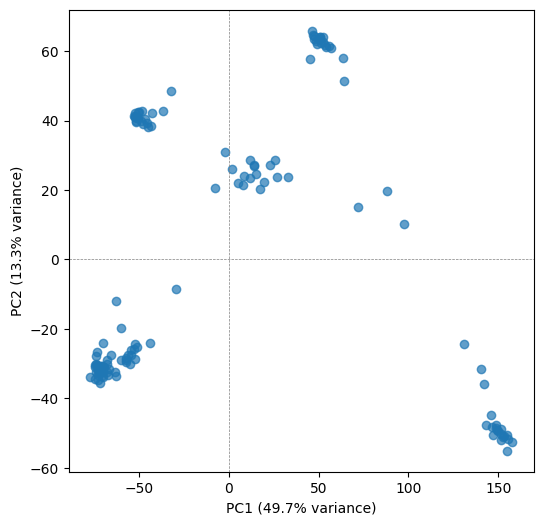

In [4]:
# Plot PC1 vs PC2
plt.figure(figsize=(6,6))
plt.scatter(pca_data[:,0], pca_data[:,1], alpha=0.7)
plt.xlabel(f"PC1 ({per_var[0]}% variance)")
plt.ylabel(f"PC2 ({per_var[1]}% variance)")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.show()


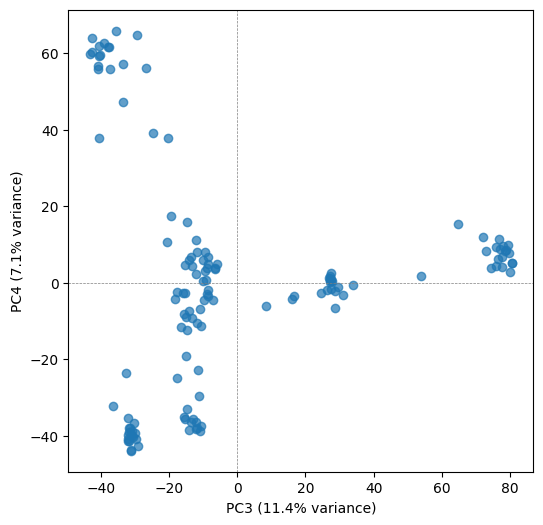

In [5]:
# Plot PC3 vs PC4
plt.figure(figsize=(6,6))
plt.scatter(pca_data[:,2], pca_data[:,3], alpha=0.7)
plt.xlabel(f"PC3 ({per_var[2]}% variance)")
plt.ylabel(f"PC4 ({per_var[3]}% variance)")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.show()

## 2. PCA Using TPM Normalization

TPM (Transcripts Per Million) normalization accounts for both sequencing depth and gene length.  
This provides a more balanced view of gene expression by reducing dominance of long genes.

Steps:  
1. Parse gene lengths from GTF file.  
2. Calculate RPK (Reads Per Kilobase).  
3. Scale RPK to TPM.  
4. Log-transform TPM values.


In [6]:
# Read GTF annotation
gtf_file = "gencode.v49.chr_patch_hapl_scaff.basic.annotation.gtf"
gtf = pd.read_csv(gtf_file, sep="\t", comment="#", header=None,
        names=["chr", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"]
)

# Keep exons only
exons = gtf[gtf["feature"] == 'exon']

# Extract gene_id
exons['gene_id'] = exons['attribute'].str.extract('gene_id "([^"]+)"')

# Calculate exon length
exons['length'] = exons['end'] - exons['start'] + 1

# Sum exon lengths per gene
gene_lengths = exons.groupby('gene_id')['length'].sum()

# Convert to kilobases
gene_lengths_kb = gene_lengths / 1000
gene_lengths_kb.index = gene_lengths_kb.index.str.split('.').str[0]

# Align genes with expression data
common_genes = expr.index.intersection(gene_lengths_kb.index)
expr_aligned = expr.loc[common_genes]
gene_lengths_aligned = gene_lengths_kb.loc[common_genes]

# Step 1: RPK
rpk = expr_aligned.div(gene_lengths_aligned, axis=0)

# Step 2: Scaling factor per sample
scaling_factor = rpk.sum(axis=0)

# Step 3: TPM
tpm = rpk.div(scaling_factor, axis=1) * 1e6

# Step 4: Log-transform
log_tpm = np.log(tpm + 1)

print("Log TPM shape:", log_tpm.shape)


/tmp/ipykernel_58479/2363610899.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exons['gene_id'] = exons['attribute'].str.extract('gene_id "([^"]+)"')
/tmp/ipykernel_58479/2363610899.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exons['length'] = exons['end'] - exons['start'] + 1


Log TPM shape: (44142, 134)


## 2.1 PCA on TPM

Perform PCA on TPM-normalized data to examine variance structure across samples.  
TPM normalization reduces bias from gene length, resulting in more evenly distributed variance across PCs.


In [7]:
# Transpose so samples are rows (for PCA)
X = log_tpm.T

# Run PCA
pca = PCA()
pca.fit(X)
pca_data = pca.transform(X)

# Get Principal components to choose the correct relevance by variance
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
cumulative_var = np.cumsum(per_var)
print('Variance explained by the first 10 PCs:\n', per_var[:10])


Variance explained by the first 10 PCs:
 [38.4 12.3 10.4  8.6  5.3  1.6  1.4  1.3  0.8  0.7]


### Scree Plot

Visualize the variance explained by each PC.
- Compare individual and cumulative variance.
- Note: More PCs are required to capture 80% variance compared to CPM.


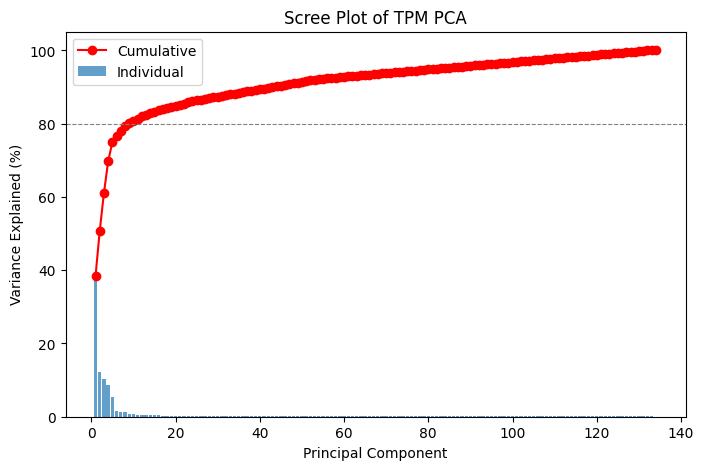

In [8]:
# Scree plot
plt.figure(figsize=(8,5))
plt.bar(range(1, len(per_var) + 1), per_var, alpha=0.7, label='Individual')
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o', color='red', label='Cumulative')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.title('Scree Plot of TPM PCA')
plt.axhline(80, color='gray', linestyle='--', linewidth=0.8)  # 80% reference line
plt.legend()
plt.show()

## 3. Hierarchical Clustering of Highly Variable Genes

To identify patterns across samples:  
1. Filter genes with low expression (mean TPM < 1).  
2. Select top 1000 most variable genes.  
3. Perform hierarchical clustering on genes and samples using Euclidean distance.


Sample order: [72, 79, 100, 106, 58, 65, 86, 113, 119, 126, 93, 133, 3, 4, 0, 1, 2, 38, 44, 51, 32, 39, 45, 87, 27, 5, 16, 127, 59, 120, 101, 52, 80, 21, 66, 94, 11, 114, 73, 107, 40, 128, 12, 28, 17, 6, 22, 33, 46, 121, 53, 60, 67, 74, 88, 108, 95, 81, 102, 115, 7, 18, 13, 23, 29, 116, 34, 41, 129, 96, 47, 122, 82, 103, 89, 109, 54, 61, 68, 75, 26, 50, 78, 125, 92, 112, 132, 10, 99, 37, 85, 71, 57, 64, 43, 30, 14, 24, 31, 8, 9, 20, 42, 36, 111, 91, 70, 118, 124, 25, 77, 56, 63, 84, 131, 98, 105, 35, 130, 104, 19, 97, 76, 55, 62, 90, 123, 48, 110, 83, 69, 117, 15, 49]
Gene order: [815, 917, 523, 337, 120, 22, 807, 663, 913, 803, 957, 577, 976, 687, 691, 747, 904, 975, 668, 997, 938, 308, 833, 553, 763, 875, 981, 383, 670, 814, 872, 936, 722, 863, 878, 505, 576, 624, 702, 556, 838, 859, 703, 761, 288, 403, 934, 341, 920, 416, 272, 157, 328, 744, 857, 622, 443, 888, 816, 563, 731, 678, 733, 506, 336, 708, 618, 672, 870, 449, 340, 683, 585, 628, 757, 332, 601, 473, 999, 232, 323, 709, 901

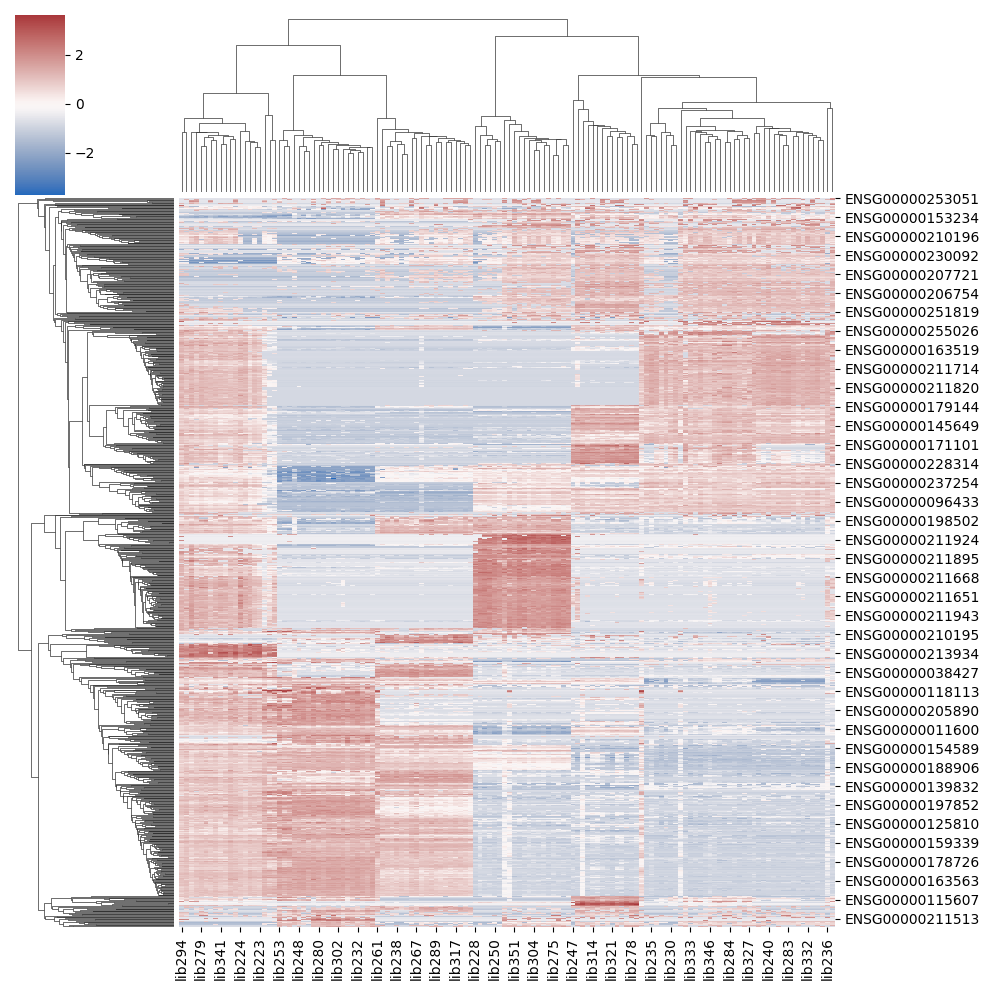

In [9]:
# Filter genes
mean_tpm = tpm.mean(axis=1)
expr_mask = mean_tpm >= 1.0
filtered = log_tpm.loc[expr_mask]

# Select top variable genes
N = 1000
gene_var = filtered.var(axis=1)
top_genes = gene_var.nlargest(N).index
subset = filtered.loc[top_genes]

# Hierarchical clustering
g = sns.clustermap(
    subset,
    metric='euclidean',
    method='average',
    z_score=0,
    cmap='vlag',
    figsize=(10,10)
)

sample_order = g.dendrogram_col.reordered_ind
gene_order = g.dendrogram_row.reordered_ind

print('Sample order:', sample_order)
print('Gene order:', gene_order)


## 4. t-SNE Visualization

t-SNE reduces high-dimensional data to 2D while preserving local relationships.  
- We use the same top 1000 variable genes as in hierarchical clustering.
- This provides an alternative view of sample clustering.


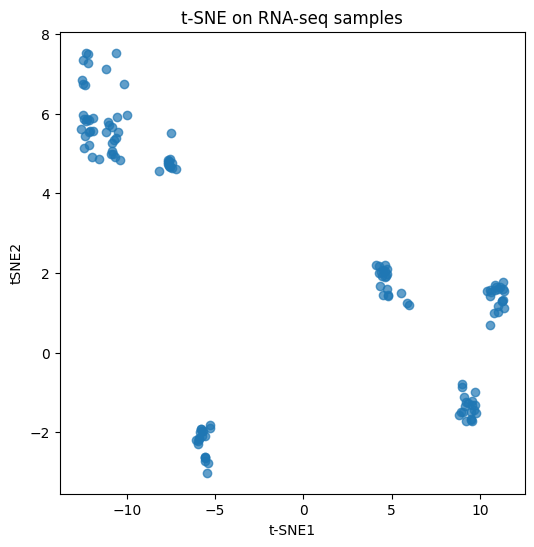

In [10]:
from sklearn.manifold import TSNE

# Take the same subset of top 1000 genes we used for clustermap() in t-SNE
X = subset.T

tsne = TSNE(n_components=2, perplexity=30)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(6,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], alpha=0.7)
plt.xlabel('t-SNE1')
plt.ylabel('tSNE2')
plt.title('t-SNE on RNA-seq samples')
plt.show()

### Insights

- Samples cluster roughly by condition (resting vs activated).  
- TPM normalization reduces bias from gene length, providing a more balanced PCA.  
- Hierarchical clustering and t-SNE reveal consistent patterns and help identify structure in the data.
